In [1]:
import os
import sys

# Set R_HOME to your Homebrew R installation
os.environ['R_HOME'] = '/opt/homebrew/Cellar/r/4.5.1/lib/R'

# Set library paths for LAPACK/BLAS
os.environ['R_LD_LIBRARY_PATH'] = '/opt/homebrew/Cellar/r/4.5.1/lib/R/lib'

# Add to dynamic library path (for macOS)
os.environ['DYLD_LIBRARY_PATH'] = '/opt/homebrew/Cellar/r/4.5.1/lib/R/lib:/opt/homebrew/Cellar/openblas/0.3.30/lib'

# Also set LD_LIBRARY_PATH (backup)
os.environ['LD_LIBRARY_PATH'] = '/opt/homebrew/Cellar/r/4.5.1/lib/R/lib:/opt/homebrew/Cellar/openblas/0.3.30/lib'

print("✓ R environment configured")
print(f"  R_HOME: {os.environ['R_HOME']}")
print(f"  R_LD_LIBRARY_PATH: {os.environ['R_LD_LIBRARY_PATH']}")

✓ R environment configured
  R_HOME: /opt/homebrew/Cellar/r/4.5.1/lib/R
  R_LD_LIBRARY_PATH: /opt/homebrew/Cellar/r/4.5.1/lib/R/lib


In [ ]:
# using Mixed-effect
import pandas as pd
import numpy as np

import StatsModel.mixed_effect_analy, importlib

importlib.reload(StatsModel.mixed_effect_analy)

from StatsModel.mixed_effect_analy import fit_lmer_event_site , fit_mixed_model_event_station
from GMfunc.prepare_resid_data import get_period_and_filter_v2

# Import conversion modules
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter


psa_list = ['resid_PGA','resid_pSA_0.02','resid_pSA_0.04','resid_pSA_0.06','resid_pSA_0.08','resid_pSA_0.1','resid_pSA_0.2',
            'resid_pSA_0.4','resid_pSA_0.6','resid_pSA_0.8',
            'resid_pSA_1.0','resid_pSA_2.0','resid_pSA_4.0','resid_pSA_6.0','resid_pSA_8.0','resid_pSA_10.0']
ped_list=[0.0,0.02,0.04,0.06,0.08,0.1,0.2,0.4,0.6,0.8,1.0,2.0,4.0,6.0,8.0,10.0]

rootfolder ='/Users/DuoL/Documents/NSHM/Attenuation/'

# modelname = 'psbah22'
# modelname = 'ag20'
modelname = 'atk22'
appendix ='_slab_backarc24'

output_dir = rootfolder + modelname + '_resd/'
loadfile = output_dir + '/resid'+ appendix + '.csv'

df_resd_used = pd.read_csv(loadfile)

print(loadfile)

df_resd_mag = df_resd_used[(df_resd_used['mag']>=4)&(df_resd_used['r_rup']<400.0)].copy()

deltaB_list = []
deltaS2S_list = []
deltaWS_list = []
bias_list = []
bias_se_list = []

for ipsa,psa in enumerate(psa_list[0:15]):

# sub table for a single component    
    df_single_all = pd.DataFrame({
        'event_id': df_resd_mag['evid'],
        'site_id': df_resd_mag['sta'],
        'fmin': df_resd_mag['fmin'],
        'resid': df_resd_mag[psa],
    })

    # filter out low frequency and less recorded events

    # filter out low frequency records

    period,df_single_filter = get_period_and_filter_v2(psa,df_single_all)
    print('period:',period)

    # check event number and site number, respectively

    event_counts = df_single_filter['site_id'].value_counts()
    events_gt_5 = event_counts[event_counts > 3].index
    df_single2 = df_single_filter[df_single_filter['site_id'].isin(events_gt_5)]


    site_counts = df_single2['event_id'].value_counts()
    site_gt_5 = site_counts[site_counts > 3].index
    df_single = df_single2[df_single2['event_id'].isin(site_gt_5)]

    print('difference in number of events:', event_counts.__len__(), df_single['event_id'].nunique() )

    df_single['event_id'] = df_single['event_id'].astype(str)
    df_single['site_id'] = df_single['site_id'].astype(str)
    df_single['lnY'] = df_single['resid'].astype('float64')

    # res = method_4_sequential_fitting(df_single)

    res = fit_lmer_event_site(df_single,y='lnY',event="event_id", site="site_id")

    bias_list.append( res['bias'])
    bias_se_list.append(res['bias_se'])
    deltaB_list.append( res['tau'])
    deltaS2S_list.append(res['phi_s2s'])
    deltaWS_list.append( res['phi'])

    # res['df_components'].to_csv(output_dir+'/M5reg-'+ psa + '-'+ modelname + appendix +'.csv')


df_sigma = pd.DataFrame({
    "record_name": psa_list,
    "period": ped_list,
    "mu": bias_list,
    "tau": deltaB_list,
    "phiSS": deltaS2S_list,
    "phiWS": deltaWS_list,
})


In [125]:
dlen = deltaB_list.__len__()

df_sigma = pd.DataFrame({
    "record_name": psa_list[0:dlen],
    "period": ped_list[0:dlen],
    "mu": bias_list[0:dlen],
    "tau": deltaB_list[0:dlen],
    "phiSS": deltaS2S_list[0:dlen],
    "phiWS": deltaWS_list[0:dlen],
})
output_dir = rootfolder + modelname + '_resd/'

df_sigma.to_csv(output_dir+'/sigma_'+ modelname + appendix +'.csv')


psa_list = psa_list[0:dlen]
ped_list = ped_list[0:dlen]

event type slab
appendix _slab_backarc24


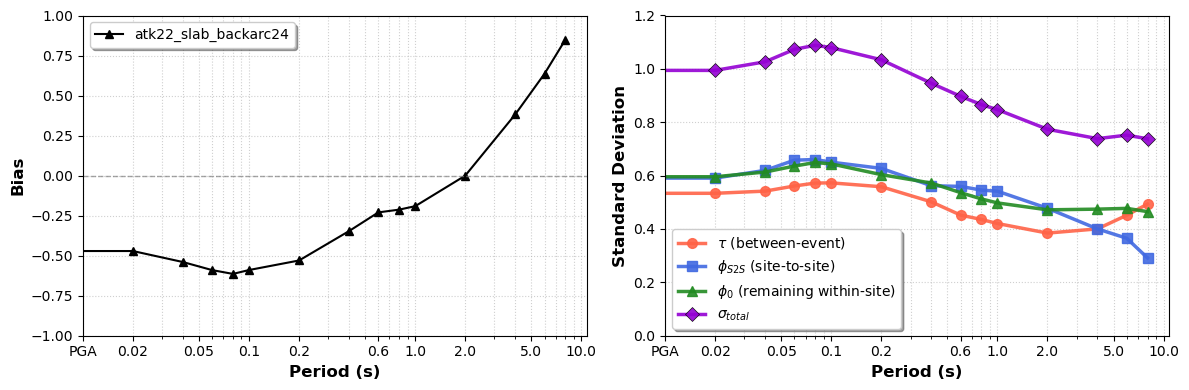

In [126]:
events_select='slab'

print('event type',events_select)
print('appendix',appendix)

import matplotlib.pyplot as plt
# Create discrete colormap with 5 colors
from matplotlib.colors import ListedColormap
colors_discrete = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']  # Red, Blue, Green, Purple, Orange
cmap_discrete = ListedColormap(colors_discrete)

# Calculate total standard deviation
deltaTotal_list = [np.sqrt(tau**2 + phi_s2s**2 + phi_ws**2) 
                   for tau, phi_s2s, phi_ws in zip(deltaB_list, deltaS2S_list, deltaWS_list)]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(ped_list, bias_list, '-^', c='k', linewidth=1.5, zorder=2, 
             label=modelname + appendix)

axes[0].set_xscale('log')
axes[0].set_ylim([-1.0, 1.0])
axes[0].set_xlabel('Period (s)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Bias', fontsize=12, fontweight='bold')
axes[0].axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
axes[0].legend(loc='best', frameon=True, shadow=True, fontsize=10)
axes[0].grid(which='both', linestyle=':', alpha=0.6)
axes[0].tick_params(axis='both', which='major', labelsize=10)

axes[0].set_xticks([0.01, 0.02, 0.05, 0.1, 0.2, 0.6, 1.0, 2.0, 5.0, 10.0])
axeslabels = ['PGA', '0.02', '0.05', '0.1', '0.2', '0.6', '1.0', '2.0', '5.0', '10.0']
axes[0].set_xticklabels(axeslabels)

# Second subplot - Standard deviation components + Total


axes[1].plot(ped_list, deltaB_list, '-o', c='tomato', label=r'$\tau$ (between-event)', 
             linewidth=2.5, markersize=7, alpha=0.9)
axes[1].plot(ped_list, deltaS2S_list, '-s', c='royalblue', label=r'$\phi_{S2S}$ (site-to-site)', 
             linewidth=2.5, markersize=7, alpha=0.9)
axes[1].plot(ped_list, deltaWS_list, '-^', c='forestgreen', label=r'$\phi_{0}$ (remaining within-site)', 
             linewidth=2.5, markersize=7, alpha=0.9)
axes[1].plot(ped_list, deltaTotal_list, '-D', c='darkviolet', label=r'$\sigma_{total}$', 
             linewidth=2.5, markersize=7, alpha=0.9, markeredgecolor='black', markeredgewidth=0.5)

axes[1].set_xscale('log')
axes[1].set_ylim([0.0, 1.2])
axes[1].set_xlabel('Period (s)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Standard Deviation', fontsize=12, fontweight='bold')
axes[1].legend(loc='best', frameon=True, shadow=True, fontsize=10)
axes[1].grid(which='both', linestyle=':', alpha=0.6)
axes[1].tick_params(axis='both', which='major', labelsize=10)

axes[1].set_xticks([0.01, 0.02, 0.05, 0.1, 0.2, 0.6, 1.0, 2.0, 5.0, 10.0])
axeslabels = ['PGA', '0.02', '0.05', '0.1', '0.2', '0.6', '1.0', '2.0', '5.0', '10.0']
axes[1].set_xticklabels(axeslabels)

plt.tight_layout()

plt.savefig(modelname + '-' + events_select + appendix + '-bias.png', dpi=300, bbox_inches='tight')

plt.show()

In [13]:
import pymer4, polars as pl, pyarrow as pa
from pymer4 import version
print("pymer4:", version.__version__)
print("polars ok:", hasattr(pl, "DataFrame"))
print("pyarrow ok:", hasattr(pa, "Table"))

pymer4: 0.9.2
polars ok: True
pyarrow ok: True


In [123]:
importlib.reload(StatsModel.mixed_effect_analy)

from StatsModel.mixed_effect_analy import *

df_test = pd.DataFrame({
    "lnY": df_single['resid'],
    "evid": df_single['event_id'],
    "sta": df_single["site_id"]
})


compare_all_methods(df_test)

COMPARISON: Python Mixed Linear Regression Methods
Model: lnY ~ 1 + (1|evid) + (1|sta)
Data shape: (740, 3)
Events (evid): 68
Stations (sta): 95



pymer4 not installed. Install with:
pip install pymer4
Note: Requires R and rpy2

METHOD 3: statsmodels (SIMILAR, NOT IDENTICAL)

3a: Single random effect (evid only)
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: lnY      
No. Observations: 740     Method:             REML     
No. Groups:       68      Scale:              0.2637   
Min. group size:  4       Log-Likelihood:     -602.8489
Max. group size:  50      Converged:          Yes      
Mean group size:  10.9                                 
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.844    0.040 21.095 0.000  0.766  0.923
Group Var     0.076    0.039                           


3b: Variance compone

/Users/DuoL/opt/miniconda3/envs/openquake/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/DuoL/opt/miniconda3/envs/openquake/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2704: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


{'statsmodels': {'intercept': 0.8003386240673147,
  'identical_to_r': False,
  'notes': 'Similar but different optimization'}}